### Libraries

In [3]:
import pandas as pd
import numpy as np
import math 
import random
import matplotlib.pyplot as plt
import csv

In [4]:
padding=50; # non-informative addded characters to a string to the ends of it for formatting purposes.

### TOU for long Island NYISO (https://www.nyiso.com/energy-market-operational-data)

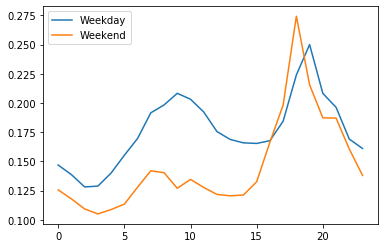

In [7]:
price=[[29.37,27.73,25.62,25.76,28.00,31.04,33.92,38.31,39.66,41.65,40.64,38.45,
      35.10,33.75,33.17,33.07,33.54,36.88,44.80,50.00,41.64,39.25,33.81,32.21],# March 19.2021(friday)
    [25.12,23.58,21.85,21.00,21.75,22.67,25.57,28.38,28.06,25.39,26.91,25.53,
     24.34,24.10,24.24,26.51,33.29,39.64,54.85,43.11,37.45,37.41,32.11,27.59]];# March 13.2021(sunday)

tou= np.array(price)/200

plt.plot(tou[0],label = 'Weekday')
plt.plot(tou[1],label = 'Weekend')
plt.legend()

tou

f1 = open('tou.csv', 'w', newline='')
with f1:
    writer = csv.writer(f1)
    writer.writerows(tou) 

### Activity label for the 2 residents of Home 2, from ARAS dataset

In [5]:
activity= np.zeros((2, 43200+padding), dtype=int); # row represents the 2 residents, column represents the 15 minute time slots in a month
activity[:,0:43200]=np.array(pd.read_csv('House_B_flattened_activity.csv', header= None), dtype=int);
activity[:,43200]=11; ## the additional minute of the month is sleep(=11)

current_activity= np.zeros((2,30*96+padding), dtype=int) 
previous_activity=  np.zeros((2,30*96+padding), dtype=int) 
duration=  np.zeros((2,30*96+padding), dtype=int) # current activity duration

                ### Resident-1

# Initial assumption
current_activity[0,0]= 10; # Having snack
previous_activity[0,0]= 17;# Using Internet 
duration[0,0]= 6;  

for t in range(30*96):
	num_change=0;    
	for m in range(15):        
		if activity[0,t*15+15-m]!=activity[0,t*15+14-m]:
			num_change+=1;  
			if num_change==1:  # the resident changed his activity once during the last 15 minutes           
				current_activity[0,t+1]=activity[0,t*15+14-m];
				previous_activity[0,t+1]=current_activity[0,t];                
				duration[0,t+1]=m+1;
			if num_change==2:  # the resident changed his activity twice during the last 15 minutes                     
				previous_activity[0,t+1]=activity[0,t*15+14-m];                
	if num_change==0: # the resident continued the same activity for the last 15 minutes
		current_activity[0,t+1]=current_activity[0,t];
		previous_activity[0,t+1]=previous_activity[0,t];                
		duration[0,t+1]=duration[0,t]+15;
        
        
                ### Resident-2

# Initial assumption
current_activity[1,0]= 10; #Talking on the phone
previous_activity[1,0]= 17;#Using Internet 
duration[1,0]= 8;  
for t in range(30*96): 
	num_change=0;    
	for m in range(15):        
		if activity[1,t*15+15-m]!=activity[1,t*15+14-m]:
			num_change+=1;  
			if num_change==1:            
				current_activity[1,t+1]=activity[1,t*15+14-m];
				previous_activity[1,t+1]=current_activity[1,t];                
				duration[1,t+1]=m+1;
			if num_change==2:            
				previous_activity[1,t+1]=activity[1,t*15+14-m];                
	if num_change==0:
		current_activity[1,t+1]=current_activity[1,t];
		previous_activity[1,t+1]=previous_activity[1,t];                
		duration[1,t+1]=duration[1,t]+15;    
        
f2 = open('current_activity.csv', 'w', newline='')
with f2:
    writer = csv.writer(f2)
    writer.writerows(current_activity)  

f3 = open('duration.csv', 'w', newline='')
with f3:
    writer = csv.writer(f3)
    writer.writerows(duration)     
    
f4 = open('previous_activity.csv', 'w', newline='')
with f4:
    writer = csv.writer(f4)
    writer.writerows(previous_activity) 

### AC Data

In [31]:
AC_status= np.zeros((1,30*96+padding),dtype=int)
for t in range(30*96):
	num_change=0;    
	for m in range(15):            
		if activity[0,t*15+15]== 2 and activity[1,t*15+15]== 2: 
			AC_status[0,t]=0
		else: AC_status[0,t]=1 # AC remains in active status if any of the resident is at home 
            
f5 = open('AC_status.csv', 'w', newline='')
with f5:
    writer = csv.writer(f5)
    writer.writerows(AC_status)             

### DW data

In [19]:
DW_activation_number=  np.zeros((1,30*96+padding), dtype=int) # Dishwash Time Schedule
DW_activation_time=  np.zeros((1,30), dtype=int) # DW activation events; DW events <30 in a month
wash_dish=0; # Counter for dishwashing events
cooking=np.array([3, 5, 7]) # labels for cooking breakfast, lunch and dinner respectively
dish_delay= np.zeros(30, dtype=int) # delay between having dinner and start dishwash
for d in range(30):
	cook=0; # initialize number of cooking events 0 at the start of a day
	dinner=0; # initialize number of residents had dinner 0 at the start of a day
    
	for t in range(96*15):
    
		if (activity[0,d*96*15+t]==cooking).any() or (activity[1,d*96*15+t]==cooking).any(): # if any cooking happened 
			cook=1;
			break
                
	for u in range(96*15-t):
    
		if activity[0,d*96*15+t+u]==8 or activity[0,d*96*15+t+u]==8: # if any dinner done at home 
			dinner=1;
			break 
	if cook==1 and dinner==1: # Dishwashing happens if cooking and dinner both happened in a day
		wash_dish+=1 
        
	dish_delay[wash_dish-1]=np.random.poisson(4)  ## People donot always start diswash after dinner,poisson mean 4=(1hour)              
	DW_activation_number[0,int(np.floor((t+u)/15))+1+dish_delay[wash_dish-1]+d*96:]=wash_dish  # Dishwash Time Schedule          
	DW_activation_time[0,wash_dish]=int(np.floor((t+u)/15))+1+dish_delay[wash_dish-1]+d*96
import csv
f6 = open('DW_activation_number.csv', 'w', newline='')
with f6:
    writer = csv.writer(f6)
    writer.writerows(DW_activation_number) 
    
f7 = open('DW_activation_time.csv', 'w', newline='')
with f7:
    writer = csv.writer(f7)
    writer.writerows(DW_activation_time)    

### Cloth W&D data

In [29]:
shower_index=  np.zeros((1,30*96+padding), dtype=int) # Shower Time Schedule
shower_count=0 # Counter for total shower done by the residents

WD_activation_number=  np.zeros((1,30*96+padding), dtype=int) # WD Time Schedule
wash_count=0 # Counter for Cloth Washing events
wash_delay= np.zeros(30, dtype=int) # delay between cloth fill and start cloth wash
WD_activation_time=  np.zeros((1,30), dtype=int) # WD in active status duration; WD events <30 in a month

for t in range(30*96):
    
	for m in range(15):        
		if (activity[0,t*15+m]==14 and activity[0,t*15]!=14) or (activity[1,t*15+m]==14 and activity[1,t*15]!=14):
            # and statement confirms it does not count the same shower between 2 interval as twice            
			shower_count+=1;
			if shower_count%(random.randint(2, 3))==0 and  shower_count/(random.randint(2, 3))>0: #WD occurs after second or third bath (with equal probability) from the  previous  laundry
				wash_count+=1; 
				wash_delay[wash_count-1]=np.random.poisson(2)
			break
            
	shower_index[0,t+1]=shower_count            
	WD_activation_number[0,t+1+wash_delay[wash_count-1]]=wash_count 
	WD_activation_time[0,wash_count]=  t+1+wash_delay[wash_count-1]               
    
import csv
f8 = open('WD_activation_number.csv', 'w', newline='')
with f8:
    writer = csv.writer(f8)
    writer.writerows(WD_activation_number) 
    
f9 = open('shower_index.csv', 'w', newline='')
with f9:
    writer = csv.writer(f9)
    writer.writerows(shower_index) 
    
f10= open('WD_activation_time.csv', 'w', newline='')
with f10:
    writer = csv.writer(f10)
    writer.writerows(WD_activation_time)     

### EV battery

In [7]:
ev_in0_out1 = np.zeros((1,30*96*15+padding))
man_out=0
for t in range(30*96*15):   
	if activity[1,t]==2: # 2nd resident's activity[1,time]           
		man_out+= 1; 
		if man_out==15: # resident going out for less than 15 minutes is considered no vehicle use
			ev_in0_out1[0,(t-14):(t+1)]=1
		if  man_out>15: 
			ev_in0_out1[0,t]=1
	if activity[1,t]!=2: 
		man_out= 0;

In [23]:
mu=0.33; #driving time coefficient alpha
sigma=0.1;
trip_time= np.zeros((1,22), dtype=int) # 22 trips happened (pre-estimated)
ev_battery_usage=  np.zeros((1,22))  
travel= np.zeros((1,22), dtype=int); # office or leasure trip=0, travel=1
travel_prep= np.zeros((1,30*96), dtype=int);

#Initialize
trip=0
battery=0.5; # 50% charged battery at initialization
battery_use=0
last_charge=0
car_out=0

for t in range(30*96*15-1):
   
	if ev_in0_out1[0,t]==1:         
		car_out+= 1; 
		if ev_in0_out1[0,t+1]!=1:
			trip_time[0,trip]= car_out 
			if car_out<600 and (t%(1440*7)==0 or t%(1440*7)==6): # weekeend , leisure trip
				battery_use= (np.random.normal(mu, sigma)*(car_out/60)*30)/220;  
				ev_battery_usage[0,trip]=battery_use 
				battery-= battery_use 
                
			if car_out > 599 and (t%(1440*7)==0 or t%(1440*7)==6): # weekeend , travel
				battery= np.random.normal(0.2, 0.05); # EV returns with 20% mean battery charge
				ev_battery_usage[0,trip]=0.9-battery                                 
				travel[0,trip]=1; # travel flag
				travel_prep[0, int((t-car_out)/15)-24:int((t-car_out)/15)]=1   
                
			if car_out<480 and (t%(1440*7)!=0 and t%(1440*7)!=6): # weekday , leisure trip
				battery_use= (np.random.normal(mu, sigma)*(car_out/60)*30)/220;            
				battery-= battery_use 
				ev_battery_usage[0,trip]=battery_use 
               
			if 479<car_out<600 and (t%(1440*7)!=0 and t%(1440*7)!=6): # weekday , office trip
				battery_use= (40)/220;            
				battery-= battery_use 
				ev_battery_usage[0,trip]=battery_use 
                
			if 599<car_out<960 and (t%(1440*7)!=0 and t%(1440*7)!=6): # weekday , office+leisure trip
				battery_use= (40+ np.random.normal(mu, sigma)*((car_out-600)/60)*30)/220;            
				battery-= battery_use 
				ev_battery_usage[0,trip]=battery_use 
               
			if car_out>959 and (t%(1440*7)!=0 and t%(1440*7)!=6): # weekday , travel
				battery= np.random.normal(0.2, 0.05); # EV returns with 20% mean battery charge
				ev_battery_usage[0,trip]=0.9-battery_use 
				travel[0,trip]=1; # travel flag
				travel_prep[0, int((t-car_out)/15)-24:int((t-car_out)/15)]=1   
                
			car_out= 0; 
			trip+=1 

In [24]:
f11 = open('ev_status.csv', 'w', newline='')
with f11:
    writer = csv.writer(f11)
    writer.writerows(ev_in0_out1) 
    
     
f12 = open('trip_time.csv', 'w', newline='')
with f12:
    writer = csv.writer(f12)
    writer.writerows(trip_time)    
    
f13 = open('ev_battery_usage.csv', 'w', newline='')
with f13:
    writer = csv.writer(f13)
    writer.writerows(ev_battery_usage)  

f14 = open('travel_prep.csv', 'w', newline='')
with f14:
    writer = csv.writer(f14)
    writer.writerows(travel_prep) 
